# Intro


In [312]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import hashlib

# Data Analysis

We load the original dataset to check its structure and data types. We can see there are no missing/null values and no rows that are duplicated entirely.

In [313]:
original_dataset = pd.read_csv("dataset_2025.csv")

# All anonymization processes will be done on this copy
dataset = original_dataset.copy()
duplicates = dataset.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}\n")

dataset.info()
dataset.head()

Number of duplicate rows: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   name                150000 non-null  object 
 1   gender              150000 non-null  object 
 2   dob                 150000 non-null  object 
 3   postcode            150000 non-null  object 
 4   marital_status      150000 non-null  object 
 5   education           150000 non-null  object 
 6   employment          150000 non-null  object 
 7   num_children        150000 non-null  int64  
 8   home_ownership      150000 non-null  object 
 9   ethnicity           150000 non-null  object 
 10  income              150000 non-null  float64
 11  on_benefits         150000 non-null  bool   
 12  malnutrition_score  150000 non-null  float64
 13  disease             150000 non-null  object 
dtypes: bool(1), float64(2), int64(1), object(10)
memory usa

,name,gender,dob,postcode,marital_status,education,employment,num_children,home_ownership,ethnicity,income,on_benefits,malnutrition_score,disease
0,James Taylor,male,24/10/1991,HX82 5XH,married,Bachelor,Student,6,Rent flat,English-Scottish,14484.06,False,37.86,heart failure
1,Robert Smith,male,13/07/2011,TN46 9DG,married,Bachelor,Retired,9,Rent house,Arab,26390.93,False,19.25,prostate cancer
2,Elizabeth Smith,female,21/07/1959,RH3 3FH,widowed,PhD/md,Unemployed,0,Rent room,Caribbean,21033.32,False,19.37,breast cancer
3,Linda Jones,female,24/09/2004,OX24 8NE,single,Masters,Retired,0,Rent room,Asian,30213.75,False,38.27,tuberculosis
4,David Taylor,male,26/09/2002,EH9 2YX,divorced,Less than High School,Employed,7,Rent room,other,42744.18,False,14.92,endometriosis


In [314]:
# Check for duplicate identifiers
print("Number of people with duplicate names: ", dataset.duplicated(subset=["name"], keep=False).sum())
print("Number of people with duplicate names and dobs: ", dataset.duplicated(subset=["name", "dob"], keep=False).sum())
print("Number of people with the duplicate names, dobs, and postcodes: ", dataset.duplicated(subset=["name", "dob", "postcode"], keep=False).sum())

Number of people with duplicate names:  150000
Number of people with duplicate names and dobs:  21299
Number of people with the duplicate names, dobs, and postcodes:  0


### Original Distrbution

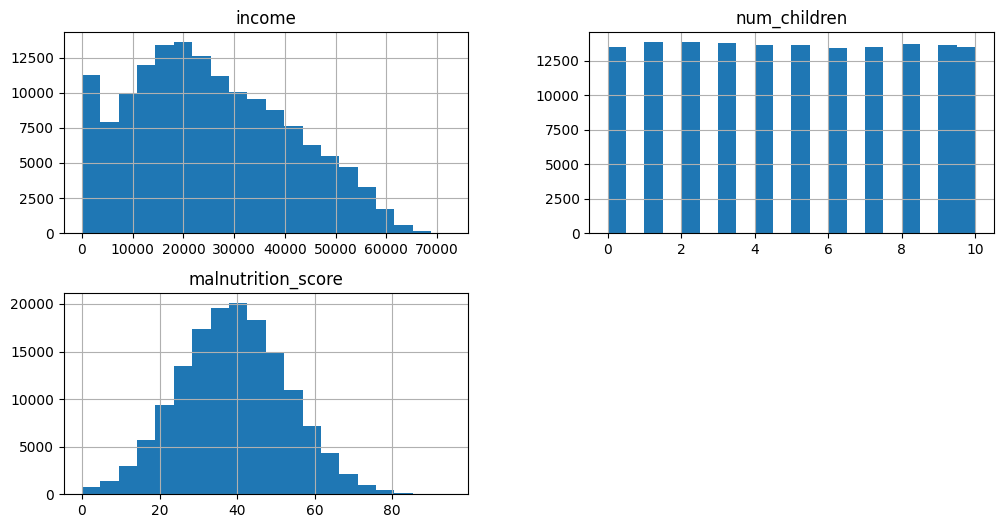

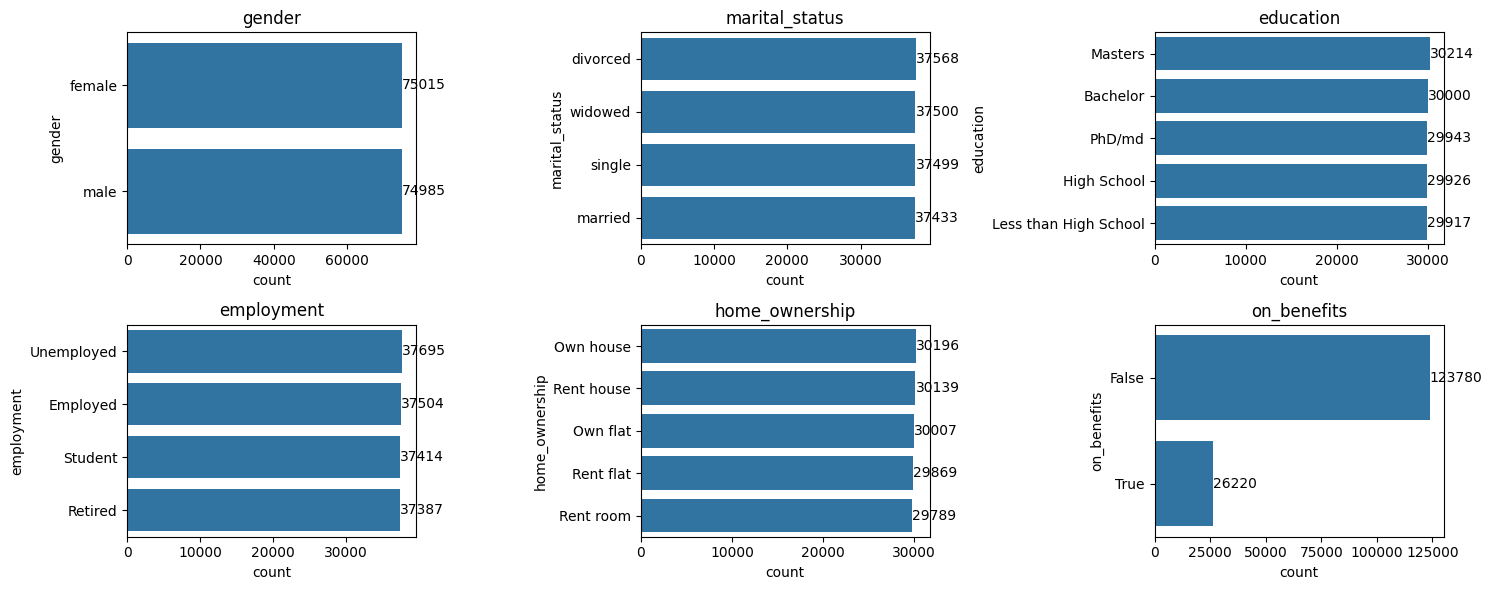

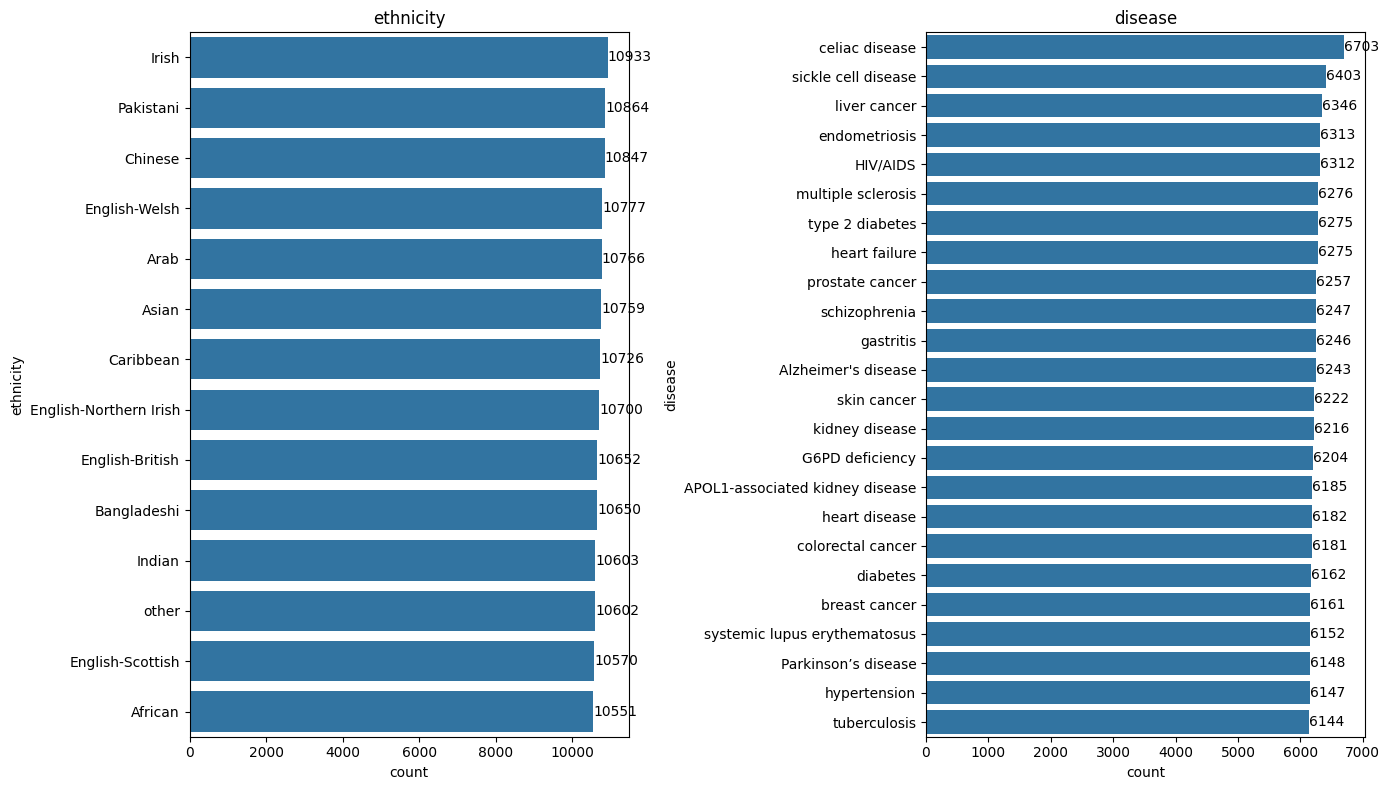

In [315]:
# numeric features
numeric_cols = ['income', 'num_children', 'malnutrition_score']
dataset[numeric_cols].hist(bins=20, figsize=(12,6))
plt.show()

# categorical features
categorical_cols_small = [
    'gender', 'marital_status', 'education', 'employment',
    'home_ownership', 'on_benefits'
]
categorical_cols_large = ['ethnicity', 'disease']

# small plots
fig, axes = plt.subplots(2, 3, figsize=(15, 6))
for ax, col in zip(axes.flat, categorical_cols_small):
    sns.countplot(y=col, data=dataset, ax=ax, order=dataset[col].value_counts().index)
    ax.set_title(col)

    for p in ax.patches:
        count = int(p.get_width())  # bar length is the count for horizontal bars
        ax.text(p.get_width() + 0.1,               # x position (a bit past the bar)
                p.get_y() + p.get_height() / 2,    # y position (center of bar)
                f'{count}',                        # text
                va='center')                       # vertical alignment
        
plt.tight_layout()
plt.show()

# large plots
fig, axes = plt.subplots(1, 2, figsize=(14, 8))
for ax, col in zip(axes, categorical_cols_large):
    sns.countplot(y=col, data=dataset, ax=ax, order=dataset[col].value_counts().index)
    ax.set_title(col)

    for p in ax.patches:
        count = int(p.get_width())  # bar length is the count for horizontal bars
        ax.text(p.get_width() + 0.1,               # x position (a bit past the bar)
                p.get_y() + p.get_height() / 2,    # y position (center of bar)
                f'{count}',                        # text
                va='center')                       # vertical alignment
plt.tight_layout()
plt.show()

# Use Cases

Must retain utility for analysis → these attributes will not be overly generalized.


Use Case 1: Ethnicity ↔ Disease

- Key attributes: `ethnicity`, `disease`


Use Case 2: Fairness in on_benefits Decision

- Key attributes: `income`, `gender`, `ethnicity`, `dob`
- should preserve distribution to detect bias


Use Case 3: Geographic + Qualifications ↔ Malnutrition

- Key attributes: `postcode`, `education`, `malnutrition_score`


# Attribute Categories

Direct identifiers

- `name` is unique for each row, should be removed entirely and just use a pseudoID.

Quasi-identifiers

- `gender`, `dob`, `postcode`, `ethnicity`, `employment`, `income` → can be used to re-identify individuals when combined; should be generalized or perturbed (benchmarking on effect on utility).

- `marital_status` and `home_ownership` could also act as quasi-identifiers depending on context.

Sensitive attributes

- `disease`, `malnutrition_score`, `on_benefits` → must be protected from inference attacks.

Non-sensitive attributes

- `education`, `num_children` → can be kept as-is or slightly generalized (e.g., grouping).

# Hashing


In [316]:
# Salt is a randomly generated string added to hashing input
salt = "h1wekchecp6ioncjhkgbauil2rioefnolcn8oiq[wqdwc]ev"

# Add a new hashed column to dataset as id 
hashing_input = dataset["name"] + dataset["dob"] + dataset["postcode"] + salt 
hashing_output = hashing_input.apply(lambda x: hashlib.sha256(x.encode()).hexdigest())
dataset["id"] = hashing_output

# Display the first few rows of the updated dataset 
hashed_dataset = dataset.set_index("id")
hashed_dataset.head(5)

,name,gender,dob,postcode,marital_status,education,employment,num_children,home_ownership,ethnicity,income,on_benefits,malnutrition_score,disease
id,,,,,,,,,,,,,,
b755b621af78df97992d20a0d7acd3a01fe5a9212f81fa2f5a88f8afe949f863,James Taylor,male,24/10/1991,HX82 5XH,married,Bachelor,Student,6,Rent flat,English-Scottish,14484.06,False,37.86,heart failure
d413549638f33324d7874c199018a413153023f17f91d26548b8a26478a753fa,Robert Smith,male,13/07/2011,TN46 9DG,married,Bachelor,Retired,9,Rent house,Arab,26390.93,False,19.25,prostate cancer
6a4af7a212cc91fa414f43810137f676f56349c98be01a5ac1b2b3766e148cb0,Elizabeth Smith,female,21/07/1959,RH3 3FH,widowed,PhD/md,Unemployed,0,Rent room,Caribbean,21033.32,False,19.37,breast cancer
efc8f78ee308e9a6afe0dd4710793c37d81a9677c81e430625f68084c6980894,Linda Jones,female,24/09/2004,OX24 8NE,single,Masters,Retired,0,Rent room,Asian,30213.75,False,38.27,tuberculosis
f6ce642261cb8fae4d0ae114e7d6880393de85e10bab391fca0eb2d2021b335b,David Taylor,male,26/09/2002,EH9 2YX,divorced,Less than High School,Employed,7,Rent room,other,42744.18,False,14.92,endometriosis


# Benchmarking

### Benchmark functions for utility

Helper functions that can be called after generalizing attributes to check our methods have not changed distribution drastically and affected utility.

1. Aim for high KS similarity for numerical features: `income`, `malnutrition_score`, ...
2. Same for Chi2 on categorial features: `gender`, `education`, `ethnicity`, `disease`, ...
3. Use correlation to test relationships have been preserved: `ethnicity` <-> `disease`, `income` <-> `on_benefits`

In [317]:
from scipy.stats import ks_2samp, chi2_contingency, pearsonr

# KS test for similarity of numeric distributions
# Return: 1.0 (identical) to 0.0 (completely different)
def ks_similarity(original, transformed):
    stat, p = ks_2samp(original, transformed)
    return 1 - stat

# Chi-squared test for similarity of categorical proportions
def chi2_similarity(original, transformed):
    o_counts = original.value_counts(normalize=True)
    t_counts = transformed.value_counts(normalize=True)
    common = o_counts.index.intersection(t_counts.index)
    if len(common) < 2: 
        return 0
    contingency = np.array([o_counts[common], t_counts[common]])
    chi2, p, _, _ = chi2_contingency(contingency)
    return min(1, p)

# Test similarity of correlation between two columns c1 and c2
def corr_similarity(original, transformed, c1, c2):
    def encode(s): return pd.factorize(s)[0] if s.dtype == 'object' else s
    o_corr = pearsonr(encode(original[c1]), encode(original[c2]))[0]
    t_corr = pearsonr(encode(transformed[c1]), encode(transformed[c2]))[0]
    return 1 - abs(o_corr - t_corr)


In [318]:
def benchmark_usecase1(original, transformed):
    print("Use Case 1: Ethnicity <-> Disease\n==========")
    sim_eth = chi2_similarity(original['ethnicity'], transformed['ethnicity'])
    sim_dis = chi2_similarity(original['disease'], transformed['disease'])
    sim_corr = corr_similarity(original, transformed, 'ethnicity', 'disease')

    print(f"Ethnicity distribution similarity: {sim_eth:.3f}")
    print(f"Disease distribution similarity:   {sim_dis:.3f}")
    print(f"Ethnicity–Disease correlation similarity: {sim_corr:.3f}")

    utility_score = (sim_eth + sim_dis + sim_corr) / 3
    print(f"→ Overall utility score: {utility_score:.3f}")
    return utility_score


In [319]:
def benchmark_usecase2(original, transformed, exclude_age_days=False):
    print("Use Case 2: Fairness in on_benefits Decision\n==========")
    sims = []

    # distribution similarity
    sims.append(chi2_similarity(original['income'], transformed['income']))
    sims.append(chi2_similarity(original['gender'], transformed['gender']))
    sims.append(chi2_similarity(original['ethnicity'], transformed['ethnicity']))

    sims.append(chi2_similarity(original['marital_status'], transformed['marital_status']))
    sims.append(chi2_similarity(original['education'], transformed['education']))
    sims.append(chi2_similarity(original['employment'], transformed['employment']))
    sims.append(chi2_similarity(original['num_children'], transformed['num_children']))
    sims.append(chi2_similarity(original['home_ownership'], transformed['home_ownership']))
    if not exclude_age_days:
        sims.append(chi2_similarity(original['age_days'], transformed['age_days']))
        # sims.append(ks_similarity(original['age_days'], transformed['age_days']))

    # correlations to on_benefits
    # for c in ['income', 'gender', 'ethnicity']:
    cols = ['income', 'gender', 'ethnicity', 'marital_status', 'education', 'employment', 'num_children', 'home_ownership'] if exclude_age_days else ['income', 'gender', 'ethnicity', 'marital_status', 'education', 'employment', 'num_children', 'home_ownership', 'age_days']
    for c in cols:
        sims.append(corr_similarity(original, transformed, c, 'on_benefits'))

    print(f"Distribution similarities: income={sims[0]:.3f}, gender={sims[1]:.3f}, ethnicity={sims[2]:.3f}, marital_status={sims[1]:.3f}, education={sims[1]:.3f}, employment={sims[1]:.3f}, num_children={sims[1]:.3f}, home_ownership={sims[1]:.3f}, age_days={sims[1]:.3f}")
    print(f"Correlation similarities: income↔on_benefits={sims[3]:.3f}, gender↔on_benefits={sims[4]:.3f}, ethnicity↔on_benefits={sims[5]:.3f}, marital_status↔on_benefits={sims[5]:.3f}, education↔on_benefits={sims[5]:.3f}, employment↔on_benefits={sims[5]:.3f}, num_children↔on_benefits={sims[5]:.3f}, home_ownership↔on_benefits={sims[5]:.3f}, age_days↔on_benefits={sims[5]:.3f}")

    utility_score = np.mean(sims)
    print(f"→ Overall utility score: {utility_score:.3f}")
    return utility_score

In [ ]:
def benchmark_usecase3(original, transformed):
    print("Use Case 3: Geographic + Qualifications ↔ Malnutrition\n==========")
    sims = []

    # distribution similarities
    sims.append(chi2_similarity(original['postcode'], transformed['postcode']))
    sims.append(chi2_similarity(original['education'], transformed['education']))
    sims.append(ks_similarity(original['malnutrition_score'], transformed['malnutrition_score']))

    # correlation checks
    sims.append(corr_similarity(original, transformed, 'postcode', 'malnutrition_score'))
    sims.append(corr_similarity(original, transformed, 'education', 'malnutrition_score'))

    print(f"Distribution similarities: postcode={sims[0]:.3f}, education={sims[1]:.3f}, malnutrition={sims[2]:.3f}")
    print(f"Correlation similarities: postcode↔malnutrition={sims[3]:.3f}, education↔malnutrition={sims[4]:.3f}")

    utility_score = np.mean(sims)
    print(f"→ Overall utility score: {utility_score:.3f}")
    return utility_score


In [321]:
def benchmark_all(original, transformed, exclude_age_days=False):
    print("=== Benchmarking All Use Cases ===")
    score1 = benchmark_usecase1(original, transformed)
    print()
    score2 = benchmark_usecase2(original, transformed, exclude_age_days)
    print()
    score3 = benchmark_usecase3(original, transformed)
    print("==================================")
    overall_score = (score1 + score2 + score3) / 3
    print(f"Overall Utility Score across all use cases: {overall_score:.3f}")
    return overall_score

## Benchmark functions for privacy

In [322]:
# privacy metrics

# def get_valid_cols(dataset_, cols, verbose=False):
#     quasi = [col for col in cols if col in dataset_.columns]
#     if verbose:
#         print(f'Valid  quasi identifiers: {quasi}')
#     return quasi

# def get_valid_cols(original, anonymized, cols, verbose=False):
#     ori_quasi = [col for col in cols if col in original.columns]
#     anon_quasi = [col for col in cols if col in anonymized.columns]
#     valid_quasi = list(set(ori_quasi) & set(anon_quasi))
#     if verbose:
#         print(f'''Quasi identifiers in Original dataset: {ori_quasi}\n
#               Quasi ifentifiers in Anonymised dataset: {anon_quasi}''')
#         print(f'Valid overlapping set of quasi identifiers: {valid_quasi}')
#     return valid_quasi

def get_valid_cols(cols: list, original: pd.DataFrame, anonymized: pd.DataFrame=None, verbose=False):
    ori_cols = [col for col in cols if col in original.columns]

    if anonymized is not None:
        anon_cols = [col for col in cols if col in anonymized.columns]
        valid_cols = list(set(ori_cols) & set(anon_cols))
        if verbose:
            print(f"Quasi identifiers in Original dataset: {ori_cols}")
            print(f"Quasi identifiers in Anonymised dataset: {anon_cols}")
            print(f"Valid overlapping set of quasi identifiers: {valid_cols}")
        # assert (valid_cols==ori_cols and valid_cols==anon_cols), f"Lost QUASI, {set(ori_cols)}, {set(anon_cols)}"
    else:
        valid_cols = ori_cols
        if verbose:
            print(f"Valid quasi identifiers in dataset: {valid_cols}")

    return valid_cols


# higher entropy = more information = more utility 
def utility_entropy(dataset, quasi_identifiers):
    counts = dataset[quasi_identifiers].value_counts(normalize=True)
    return -np.sum(counts * np.log(counts))

def information_loss(original, anonymized, quasi_identifiers):
    valid_quasi = get_valid_cols(quasi_identifiers, original, anonymized)
    original_entropy = utility_entropy(original, valid_quasi)
    anonymized_entropy = utility_entropy(anonymized, valid_quasi)
    return original_entropy / anonymized_entropy

# returns group size k for given quasi-identifiers
# i.e. each combination of quasi-identifiers appears at least k times
def k_anonymity(dataset, quasi_identifiers):
    valid_quasi = get_valid_cols(quasi_identifiers, dataset)
    temp = dataset.dropna(subset=valid_quasi)
    group_sizes = temp.groupby(valid_quasi, observed=True).size()
    k = group_sizes[group_sizes > 0].min()
    return k

# returns minimum number of distinct sensitive values in any equivalence class
def l_diversity(dataset, quasi_identifiers, sensitive_col):
    valid_quasi = get_valid_cols(quasi_identifiers, dataset)
    grouped = dataset.groupby(valid_quasi, observed=True)[sensitive_col].nunique()
    l = grouped.min()
    return l


In [323]:
from scipy.stats import wasserstein_distance
from sklearn.preprocessing import MinMaxScaler

def t_closeness_fast(dataset, quasi_identifiers, sensitive_attributes, t_threshold, max_groups=2000):
    """
    Faster approximate t-closeness:
    - precomputes distributions
    - samples groups if many exist
    - bins numeric attributes
    Runtime: ~seconds for thousands of rows.
    """
    result = {}
    emd_values = []

    rng = np.random.default_rng(0)

    for sensitive_attribute in sensitive_attributes:
        result[sensitive_attribute] = []
        s = sensitive_attribute

        # normalize numeric attribute once globally
        if np.issubdtype(dataset[s].dtype, np.number):
            scaler = MinMaxScaler()
            vals_norm = scaler.fit_transform(dataset[[s]]).ravel()
            dataset['_norm_' + s] = vals_norm
        else:
            vals_norm = None

        # group indices instead of full subframes
        grouped_idx = dataset.groupby(quasi_identifiers, observed=True).indices
        groups = list(grouped_idx.items())

        # optionally subsample groups for speed
        if len(groups) > max_groups:
            chosen_idx = rng.choice(len(groups), max_groups, replace=False)
            groups = [groups[i] for i in chosen_idx]
            sampled = True
        else:
            sampled = False

        # compute global reference
        if vals_norm is not None:
            global_vals = vals_norm
        else:
            global_dist = dataset[s].value_counts(normalize=True)

        for g_value, idx in groups:
            if vals_norm is not None:
                # numeric: sample if large for faster wasserstein
                if len(idx) > 5000:
                    idx = rng.choice(idx, 5000, replace=False)
                emd = wasserstein_distance(vals_norm[idx], global_vals)
            else:
                group_dist = dataset.iloc[idx][s].value_counts(normalize=True)
                all_vals = list(set(global_dist.index).union(set(group_dist.index)))
                g_global = global_dist.reindex(all_vals, fill_value=0)
                g_group = group_dist.reindex(all_vals, fill_value=0)
                emd = 0.5 * np.abs(g_group - g_global).sum()

            emd_values.append(emd)
            result[sensitive_attribute].append({
                "group value": g_value,
                "distance": float(emd),
                "within t threshold": emd <= t_threshold
            })

        print(f"{s}: processed {len(groups)} groups{' (sampled)' if sampled else ''}.")

    MAX_EXAMPLES = 5
    for s in result:
        if len(result[s]) > MAX_EXAMPLES:
            result[s] = result[s][:MAX_EXAMPLES]

    max_emd = np.max(emd_values)
    mean_emd = np.mean(emd_values)

    return {
        "overall t closeness": float(mean_emd),
        "max emd": float(max_emd),
        "details": result
    }


In [324]:
QUASI_IDS = ['gender', 'age_days', 'education', 'home_ownership', 'num_children', 'employment', 'marital_status', 'ethnicity', 'income']

SENSITIVE_ATTRS = ['disease', 'malnutrition_score', 'on_benefits']

T_THRESHOLD = 0.2  

# runs all the helper functions above to check privacy metrics
def check_privacy(original_dataset, dataset, quasi_identifiers=QUASI_IDS, sensitive_cols=SENSITIVE_ATTRS, max_groups=5):

    report = {}

    # compute metrics
    report['information_loss'] = information_loss(original_dataset, dataset, quasi_identifiers)
    report['k_anonymity'] = k_anonymity(dataset, quasi_identifiers)
    report['l_diversity'] = {col: l_diversity(dataset, quasi_identifiers, col) for col in sensitive_cols}
    report['t_closeness'] = t_closeness_fast(dataset, quasi_identifiers, sensitive_cols, T_THRESHOLD)

    # summary printout
    print("=== Privacy Metrics Summary ===")
    print(f"Information loss (quasi-identifiers): {report['information_loss']:.3f}")
    print(f"Minimum k-anonymity: {report['k_anonymity']}")
    
    print("\nl-diversity (per sensitive column):")
    for col, val in report['l_diversity'].items():
        print(f"  {col:<20} : {val}")

    tc = report['t_closeness']
    print("\nt-closeness summary:")
    print(f"  Overall mean t-closeness     : {tc['overall t closeness']:.3f}")
    print(f"  Maximum Earth Mover Distance : {tc['max emd']:.3f}")

    # display only a few group details, otherwise too many lines
    print(f"\nExample group-level t-closeness details (showing up to {max_groups} groups per column):")
    for col, details in tc["details"].items():
        print(f"  {col}:")
        for entry in details[:max_groups]:
            print(f"    Group '{entry['group value']}' → Distance={entry['distance']:.3f}, Within threshold={entry['within t threshold']}")

    return report


# Suppression

### Dropping columns

Although `name` is not unique in this dataset (the least duplicated at 2924 entries), it is still information that could be used to identify someone and does not affect utility at all. Thus we drop it.

In [325]:
print(f"Number of unique names: {dataset['name'].nunique()}")
name_counts = dataset['name'].value_counts(ascending=True)
print(name_counts.head(2))

dataset.drop(columns=['name'], inplace=True)
print("\nDropped 'name' column.")

Number of unique names: 50
name
Robert Brown     2924
Barbara Jones    2924
Name: count, dtype: int64

Dropped 'name' column.


In [326]:
#test run benchmark functions
# exclude age_days since the column is unavailable in dataset at this stage
benchmark_all(dataset, dataset, exclude_age_days=True)

=== Benchmarking All Use Cases ===
Use Case 1: Ethnicity <-> Disease
Ethnicity distribution similarity: 1.000
Disease distribution similarity:   1.000
Ethnicity–Disease correlation similarity: 1.000
→ Overall utility score: 1.000

Use Case 2: Fairness in on_benefits Decision
Distribution similarities: income=1.000, gender=1.000, ethnicity=1.000, marital_status=1.000, education=1.000, employment=1.000, num_children=1.000, home_ownership=1.000, age_days=1.000
Correlation similarities: income↔on_benefits=1.000, gender↔on_benefits=1.000, ethnicity↔on_benefits=1.000, marital_status↔on_benefits=1.000, education↔on_benefits=1.000, employment↔on_benefits=1.000, num_children↔on_benefits=1.000, home_ownership↔on_benefits=1.000, age_days↔on_benefits=1.000
→ Overall utility score: 1.000

Use Case 3: Geographic + Qualifications ↔ Malnutrition
Distribution similarities: postcode=1.000, education=1.000, malnutrition=1.000
Correlation similarities: postcode↔malnutrition=1.000, education↔malnutrition=1

np.float64(1.0)

## Dropping Rows

### DOB to Age Translation

We derive the age in days from the 'dob', using 31 Oct 2025 as reference date. The original 'dob' column is dropped since the relevant information (age_days) has been obtained. <br>
We then perform generalization by categorising age values into buckets.


In [327]:
from datetime import datetime

REF_DATE = pd.Timestamp('2025-10-31')
def dob_to_age_days(dataset_):
	global REF_DATE
	dataset_['dob'] = pd.to_datetime(dataset_['dob'], format='%d/%m/%Y', errors='coerce')
	dataset_['age_days'] = (REF_DATE - dataset_['dob']).dt.days
	dataset_.drop(columns=['dob'], inplace=True)
	return dataset_

dataset = dob_to_age_days(dataset)
original_dataset = dob_to_age_days(original_dataset)

In [328]:
benchmark_all(original_dataset, dataset, exclude_age_days=False)

=== Benchmarking All Use Cases ===
Use Case 1: Ethnicity <-> Disease
Ethnicity distribution similarity: 1.000
Disease distribution similarity:   1.000
Ethnicity–Disease correlation similarity: 1.000
→ Overall utility score: 1.000

Use Case 2: Fairness in on_benefits Decision
Distribution similarities: income=1.000, gender=1.000, ethnicity=1.000, marital_status=1.000, education=1.000, employment=1.000, num_children=1.000, home_ownership=1.000, age_days=1.000
Correlation similarities: income↔on_benefits=1.000, gender↔on_benefits=1.000, ethnicity↔on_benefits=1.000, marital_status↔on_benefits=1.000, education↔on_benefits=1.000, employment↔on_benefits=1.000, num_children↔on_benefits=1.000, home_ownership↔on_benefits=1.000, age_days↔on_benefits=1.000
→ Overall utility score: 1.000

Use Case 3: Geographic + Qualifications ↔ Malnutrition
Distribution similarities: postcode=1.000, education=1.000, malnutrition=1.000
Correlation similarities: postcode↔malnutrition=1.000, education↔malnutrition=1

np.float64(1.0)

### Drop rows which are insensible or impractical

<u><b> Age in days & Num of children </u></b> <br>
Removes rows where person is below 16 but has 4 or more children, and where person is below 25 but has 7 or more children

In [329]:
def days(years):
	return years * 365.25 # accounts for leap years roughly

In [330]:
dataset = dataset.drop(
    dataset[
        (dataset['num_children'] >= days(4)) & 
        (dataset['age_days'] < days(16))
    ].index
)

dataset = dataset.drop(
    dataset[
        (dataset['num_children'] >= days(7)) & 
        (dataset['age_days'] < days(25))
    ].index
)

In [331]:
benchmark_all(original_dataset, dataset, exclude_age_days=False)

=== Benchmarking All Use Cases ===
Use Case 1: Ethnicity <-> Disease
Ethnicity distribution similarity: 1.000
Disease distribution similarity:   1.000
Ethnicity–Disease correlation similarity: 1.000
→ Overall utility score: 1.000

Use Case 2: Fairness in on_benefits Decision
Distribution similarities: income=1.000, gender=1.000, ethnicity=1.000, marital_status=1.000, education=1.000, employment=1.000, num_children=1.000, home_ownership=1.000, age_days=1.000
Correlation similarities: income↔on_benefits=1.000, gender↔on_benefits=1.000, ethnicity↔on_benefits=1.000, marital_status↔on_benefits=1.000, education↔on_benefits=1.000, employment↔on_benefits=1.000, num_children↔on_benefits=1.000, home_ownership↔on_benefits=1.000, age_days↔on_benefits=1.000
→ Overall utility score: 1.000

Use Case 3: Geographic + Qualifications ↔ Malnutrition
Distribution similarities: postcode=1.000, education=1.000, malnutrition=1.000
Correlation similarities: postcode↔malnutrition=1.000, education↔malnutrition=1

np.float64(1.0)

<u><b> Age in days & Employment </u></b> <br>
Removes rows where person is below 16 years old but is considered unemployed or retired

In [332]:
dataset = dataset.drop(
    dataset[
        (dataset['employment'].isin(['Unemployed', 'Retired'])) & 
        (dataset['age_days'] < days(16))
    ].index
)

In [333]:
benchmark_all(original_dataset, dataset, exclude_age_days=False)

=== Benchmarking All Use Cases ===
Use Case 1: Ethnicity <-> Disease
Ethnicity distribution similarity: 1.000
Disease distribution similarity:   1.000
Ethnicity–Disease correlation similarity: 0.997
→ Overall utility score: 0.999

Use Case 2: Fairness in on_benefits Decision
Distribution similarities: income=1.000, gender=1.000, ethnicity=1.000, marital_status=1.000, education=1.000, employment=1.000, num_children=1.000, home_ownership=1.000, age_days=1.000
Correlation similarities: income↔on_benefits=1.000, gender↔on_benefits=1.000, ethnicity↔on_benefits=1.000, marital_status↔on_benefits=1.000, education↔on_benefits=1.000, employment↔on_benefits=1.000, num_children↔on_benefits=1.000, home_ownership↔on_benefits=1.000, age_days↔on_benefits=1.000
→ Overall utility score: 0.994

Use Case 3: Geographic + Qualifications ↔ Malnutrition
Distribution similarities: postcode=1.000, education=1.000, malnutrition=0.997
Correlation similarities: postcode↔malnutrition=1.000, education↔malnutrition=0

np.float64(0.9975353394971349)

<u><b> Age in days & Marital status </u></b> <br>
Removes rows where person is below 16 (legal age for marriage in UK) but not single

In [334]:
dataset = dataset.drop(
    dataset[
        (dataset['marital_status'].isin(['married', 'divorced', 'widowed'])) & 
        (dataset['age_days'] < days(16))
    ].index
)

In [335]:
benchmark_all(original_dataset, dataset, exclude_age_days=False)

=== Benchmarking All Use Cases ===
Use Case 1: Ethnicity <-> Disease
Ethnicity distribution similarity: 1.000
Disease distribution similarity:   1.000
Ethnicity–Disease correlation similarity: 0.998
→ Overall utility score: 0.999

Use Case 2: Fairness in on_benefits Decision
Distribution similarities: income=1.000, gender=1.000, ethnicity=1.000, marital_status=1.000, education=1.000, employment=1.000, num_children=1.000, home_ownership=1.000, age_days=1.000
Correlation similarities: income↔on_benefits=1.000, gender↔on_benefits=1.000, ethnicity↔on_benefits=1.000, marital_status↔on_benefits=1.000, education↔on_benefits=1.000, employment↔on_benefits=1.000, num_children↔on_benefits=1.000, home_ownership↔on_benefits=1.000, age_days↔on_benefits=1.000
→ Overall utility score: 0.994

Use Case 3: Geographic + Qualifications ↔ Malnutrition
Distribution similarities: postcode=1.000, education=1.000, malnutrition=0.999
Correlation similarities: postcode↔malnutrition=1.000, education↔malnutrition=0

np.float64(0.9977874430967825)

<u><b> Age in days & Education </u></b> <br>
Removes rows where person is 16 or below but has education beyond high school.

In [336]:
dataset = dataset.drop(
    dataset[
        (dataset['education'].isin(['Masters', 'Bachelor', 'PhD/md'])) & 
        (dataset['age_days'] <= days(16))
    ].index
)

In [337]:
benchmark_all(original_dataset, dataset, exclude_age_days=False)

=== Benchmarking All Use Cases ===
Use Case 1: Ethnicity <-> Disease
Ethnicity distribution similarity: 1.000
Disease distribution similarity:   1.000
Ethnicity–Disease correlation similarity: 0.998
→ Overall utility score: 0.999

Use Case 2: Fairness in on_benefits Decision
Distribution similarities: income=1.000, gender=1.000, ethnicity=1.000, marital_status=1.000, education=1.000, employment=1.000, num_children=1.000, home_ownership=1.000, age_days=1.000
Correlation similarities: income↔on_benefits=1.000, gender↔on_benefits=1.000, ethnicity↔on_benefits=1.000, marital_status↔on_benefits=1.000, education↔on_benefits=1.000, employment↔on_benefits=1.000, num_children↔on_benefits=1.000, home_ownership↔on_benefits=1.000, age_days↔on_benefits=1.000
→ Overall utility score: 0.994

Use Case 3: Geographic + Qualifications ↔ Malnutrition
Distribution similarities: postcode=1.000, education=1.000, malnutrition=1.000
Correlation similarities: postcode↔malnutrition=1.000, education↔malnutrition=0

np.float64(0.997737374572361)

<u><b> Income & Benefits </u></b> <br>
Removes rows where person has income above 50k but on benefits

In [338]:
dataset = dataset.drop(
    dataset[
        (dataset['on_benefits'] == True) & 
        (dataset['income'] > 50000)
    ].index
)

In [339]:
benchmark_all(original_dataset, dataset, exclude_age_days=False)

=== Benchmarking All Use Cases ===
Use Case 1: Ethnicity <-> Disease
Ethnicity distribution similarity: 1.000
Disease distribution similarity:   1.000
Ethnicity–Disease correlation similarity: 0.998
→ Overall utility score: 0.999

Use Case 2: Fairness in on_benefits Decision
Distribution similarities: income=1.000, gender=1.000, ethnicity=1.000, marital_status=1.000, education=1.000, employment=1.000, num_children=1.000, home_ownership=1.000, age_days=1.000
Correlation similarities: income↔on_benefits=1.000, gender↔on_benefits=1.000, ethnicity↔on_benefits=1.000, marital_status↔on_benefits=1.000, education↔on_benefits=1.000, employment↔on_benefits=1.000, num_children↔on_benefits=1.000, home_ownership↔on_benefits=1.000, age_days↔on_benefits=1.000
→ Overall utility score: 0.992

Use Case 3: Geographic + Qualifications ↔ Malnutrition
Distribution similarities: postcode=1.000, education=1.000, malnutrition=0.999
Correlation similarities: postcode↔malnutrition=1.000, education↔malnutrition=0

np.float64(0.9969957519204987)

<u><b> Gender & Disease </u></b> <br>
Remove rows where Disease and Gender are incompatible. <br>
Biologically, 
- Males cannot have Endometriosis
- Females cannot have Prostate cancer

In [340]:
dataset = dataset.drop(
    dataset[
        (dataset['disease'] == 'prostate cancer') & 
        (dataset['gender'] == 'female')
    ].index
)

dataset = dataset.drop(
    dataset[
        (dataset['disease'] == 'endometriosis') & 
        (dataset['gender'] == 'male')
    ].index
)

In [341]:
benchmark_all(original_dataset, dataset, exclude_age_days=False)

=== Benchmarking All Use Cases ===
Use Case 1: Ethnicity <-> Disease
Ethnicity distribution similarity: 1.000
Disease distribution similarity:   1.000
Ethnicity–Disease correlation similarity: 0.999
→ Overall utility score: 1.000

Use Case 2: Fairness in on_benefits Decision
Distribution similarities: income=1.000, gender=1.000, ethnicity=1.000, marital_status=1.000, education=1.000, employment=1.000, num_children=1.000, home_ownership=1.000, age_days=1.000
Correlation similarities: income↔on_benefits=1.000, gender↔on_benefits=1.000, ethnicity↔on_benefits=1.000, marital_status↔on_benefits=1.000, education↔on_benefits=1.000, employment↔on_benefits=1.000, num_children↔on_benefits=1.000, home_ownership↔on_benefits=1.000, age_days↔on_benefits=1.000
→ Overall utility score: 0.992

Use Case 3: Geographic + Qualifications ↔ Malnutrition
Distribution similarities: postcode=1.000, education=1.000, malnutrition=0.999
Correlation similarities: postcode↔malnutrition=0.999, education↔malnutrition=0

np.float64(0.9970064133070206)

# Generalisation

### Age
Placed into numerical groups such that similairy scores (benchmarks) can be applied
- 0 -- <18 -- One is considered to be an adult after 18 years of age in the UK
- 1 -- [18, 40) -- Early adulthood
- 2 -- [40, 60) -- Middle aged
- 3 -- \>60 -- Elderly

In [342]:
print(f"Min age in days: {dataset['age_days'].min()}, in years {dataset['age_days'].min() /365.25}")
print(f"Max age in days: {dataset['age_days'].max()}, in years {dataset['age_days'].max() /365.25}: ")

age_days_bins = [0, days(18), days(40), days(60), days(200)]
print(age_days_bins)

# Sort age into bins 
# dataset['age_days'] = pd.cut(dataset['age_days'], age_days_bins, labels=["Below 18 years old", "Early adulthood (18 to 40)", "Middle aged (40 to 60)", "Elderly(Above 60)"])
dataset['age_days'] = pd.cut(dataset['age_days'], age_days_bins, labels=[0, 1, 2, 3])

Min age in days: 4692, in years 12.845995893223819
Max age in days: 25871, in years 70.8309377138946: 
[0, 6574.5, 14610.0, 21915.0, 73050.0]


In [343]:
benchmark_all(original_dataset, dataset, exclude_age_days=False)

=== Benchmarking All Use Cases ===
Use Case 1: Ethnicity <-> Disease
Ethnicity distribution similarity: 1.000
Disease distribution similarity:   1.000
Ethnicity–Disease correlation similarity: 0.999
→ Overall utility score: 1.000

Use Case 2: Fairness in on_benefits Decision
Distribution similarities: income=1.000, gender=1.000, ethnicity=1.000, marital_status=1.000, education=1.000, employment=1.000, num_children=1.000, home_ownership=1.000, age_days=1.000
Correlation similarities: income↔on_benefits=1.000, gender↔on_benefits=1.000, ethnicity↔on_benefits=1.000, marital_status↔on_benefits=1.000, education↔on_benefits=1.000, employment↔on_benefits=1.000, num_children↔on_benefits=1.000, home_ownership↔on_benefits=1.000, age_days↔on_benefits=1.000
→ Overall utility score: 0.937

Use Case 3: Geographic + Qualifications ↔ Malnutrition
Distribution similarities: postcode=1.000, education=1.000, malnutrition=0.999
Correlation similarities: postcode↔malnutrition=0.999, education↔malnutrition=0

np.float64(0.978506194955564)

### Income
We split income into 3 categories:
- 0 -- \<28000
- 1 -- [28000 - 50000)
- 2 -- \>50000

In [344]:
print("Min income: ", dataset['income'].min())
print("Max income: ", dataset['income'].max())

income_bins = [0, 28000, 50000, float('inf')]
dataset['income'] = pd.cut(dataset['income'], income_bins, labels=[0, 
                                                                   1,
                                                                   2], include_lowest=True)

Min income:  0.0
Max income:  72479.86


In [345]:
benchmark_all(original_dataset, dataset, exclude_age_days=False)

=== Benchmarking All Use Cases ===
Use Case 1: Ethnicity <-> Disease
Ethnicity distribution similarity: 1.000
Disease distribution similarity:   1.000
Ethnicity–Disease correlation similarity: 0.999
→ Overall utility score: 1.000

Use Case 2: Fairness in on_benefits Decision
Distribution similarities: income=0.000, gender=1.000, ethnicity=1.000, marital_status=1.000, education=1.000, employment=1.000, num_children=1.000, home_ownership=1.000, age_days=1.000
Correlation similarities: income↔on_benefits=1.000, gender↔on_benefits=1.000, ethnicity↔on_benefits=1.000, marital_status↔on_benefits=1.000, education↔on_benefits=1.000, employment↔on_benefits=1.000, num_children↔on_benefits=1.000, home_ownership↔on_benefits=1.000, age_days↔on_benefits=1.000
→ Overall utility score: 0.881

Use Case 3: Geographic + Qualifications ↔ Malnutrition
Distribution similarities: postcode=1.000, education=1.000, malnutrition=0.999
Correlation similarities: postcode↔malnutrition=0.999, education↔malnutrition=0

np.float64(0.9599075551587366)

### Postcode
In both the original and transformed datasets, we convert the postcode into numerical groups in order to apply the benchmarks. 
<br> <br>
In the transformed dataset, we keep only the outcode, represented by the first 2 to 4 characters in the postcode, before the whitespace.

In [346]:
original_dataset['postcode'] = original_dataset['postcode'].astype('category').cat.codes

In [347]:
regex = r'^([A-Z]{1,2}).*'
dataset['postcode'] = dataset['postcode'].str.split(' ').str[0].str.extract(regex)
dataset['postcode'] = dataset['postcode'].astype('category').cat.codes

In [348]:
benchmark_all(original_dataset, dataset, exclude_age_days=False)

=== Benchmarking All Use Cases ===
Use Case 1: Ethnicity <-> Disease
Ethnicity distribution similarity: 1.000
Disease distribution similarity:   1.000
Ethnicity–Disease correlation similarity: 0.999
→ Overall utility score: 1.000

Use Case 2: Fairness in on_benefits Decision
Distribution similarities: income=0.000, gender=1.000, ethnicity=1.000, marital_status=1.000, education=1.000, employment=1.000, num_children=1.000, home_ownership=1.000, age_days=1.000
Correlation similarities: income↔on_benefits=1.000, gender↔on_benefits=1.000, ethnicity↔on_benefits=1.000, marital_status↔on_benefits=1.000, education↔on_benefits=1.000, employment↔on_benefits=1.000, num_children↔on_benefits=1.000, home_ownership↔on_benefits=1.000, age_days↔on_benefits=1.000
→ Overall utility score: 0.881

Use Case 3: Geographic + Qualifications ↔ Malnutrition
Distribution similarities: postcode=1.000, education=1.000, malnutrition=0.999
Correlation similarities: postcode↔malnutrition=1.000, education↔malnutrition=0

np.float64(0.9599544913938006)

### Number of children

In [349]:
num_children_bins = [0, 3, 6, dataset['num_children'].max()]
dataset['num_children'] = pd.cut(dataset['num_children'], num_children_bins, labels=[0, 1, 2], right=True, include_lowest=True)

In [350]:
benchmark_all(original_dataset, dataset, exclude_age_days=False)

=== Benchmarking All Use Cases ===
Use Case 1: Ethnicity <-> Disease
Ethnicity distribution similarity: 1.000
Disease distribution similarity:   1.000
Ethnicity–Disease correlation similarity: 0.999
→ Overall utility score: 1.000

Use Case 2: Fairness in on_benefits Decision
Distribution similarities: income=0.000, gender=1.000, ethnicity=1.000, marital_status=1.000, education=1.000, employment=1.000, num_children=1.000, home_ownership=1.000, age_days=1.000
Correlation similarities: income↔on_benefits=1.000, gender↔on_benefits=1.000, ethnicity↔on_benefits=1.000, marital_status↔on_benefits=1.000, education↔on_benefits=1.000, employment↔on_benefits=1.000, num_children↔on_benefits=1.000, home_ownership↔on_benefits=1.000, age_days↔on_benefits=1.000
→ Overall utility score: 0.881

Use Case 3: Geographic + Qualifications ↔ Malnutrition
Distribution similarities: postcode=1.000, education=1.000, malnutrition=0.999
Correlation similarities: postcode↔malnutrition=1.000, education↔malnutrition=0

np.float64(0.9598983979393853)

### Education

In [351]:
dataset.loc[dataset['education'].isin(['Masters', 'PhD/md', 'Bachelor']), 'education'] = 'Degree'
mapping = {'Less than High School': 0, 'High School': 1, 'Degree': 2}
dataset['education'] = dataset['education'].map(mapping)

In [352]:
benchmark_all(original_dataset, dataset, exclude_age_days=False)

=== Benchmarking All Use Cases ===
Use Case 1: Ethnicity <-> Disease
Ethnicity distribution similarity: 1.000
Disease distribution similarity:   1.000
Ethnicity–Disease correlation similarity: 0.999
→ Overall utility score: 1.000

Use Case 2: Fairness in on_benefits Decision
Distribution similarities: income=0.000, gender=1.000, ethnicity=1.000, marital_status=1.000, education=1.000, employment=1.000, num_children=1.000, home_ownership=1.000, age_days=1.000
Correlation similarities: income↔on_benefits=1.000, gender↔on_benefits=0.000, ethnicity↔on_benefits=1.000, marital_status↔on_benefits=1.000, education↔on_benefits=1.000, employment↔on_benefits=1.000, num_children↔on_benefits=1.000, home_ownership↔on_benefits=1.000, age_days↔on_benefits=1.000
→ Overall utility score: 0.814

Use Case 3: Geographic + Qualifications ↔ Malnutrition
Distribution similarities: postcode=1.000, education=0.000, malnutrition=0.999
Correlation similarities: postcode↔malnutrition=1.000, education↔malnutrition=0

np.float64(0.8431650195148522)

### Employment

In [353]:
dataset.loc[dataset['employment'].isin(['Unemployed', 'Student', 'Retired']), 'employment'] = 'Non-working'
mapping = {'Non-working': 0, 'Employed': 1}
dataset['employment'] = dataset['employment'].map(mapping)

In [354]:
benchmark_all(original_dataset, dataset, exclude_age_days=False)

=== Benchmarking All Use Cases ===
Use Case 1: Ethnicity <-> Disease
Ethnicity distribution similarity: 1.000
Disease distribution similarity:   1.000
Ethnicity–Disease correlation similarity: 0.999
→ Overall utility score: 1.000

Use Case 2: Fairness in on_benefits Decision
Distribution similarities: income=0.000, gender=1.000, ethnicity=1.000, marital_status=1.000, education=1.000, employment=1.000, num_children=1.000, home_ownership=1.000, age_days=1.000
Correlation similarities: income↔on_benefits=1.000, gender↔on_benefits=0.000, ethnicity↔on_benefits=0.000, marital_status↔on_benefits=0.000, education↔on_benefits=0.000, employment↔on_benefits=0.000, num_children↔on_benefits=0.000, home_ownership↔on_benefits=0.000, age_days↔on_benefits=0.000
→ Overall utility score: 0.759

Use Case 3: Geographic + Qualifications ↔ Malnutrition
Distribution similarities: postcode=1.000, education=0.000, malnutrition=0.999
Correlation similarities: postcode↔malnutrition=1.000, education↔malnutrition=0

np.float64(0.8247708614083272)

### Ethnicity

In [355]:
dataset.loc[dataset['ethnicity'].isin(['English-British', 'English-Northern Irish', 'English-Welsh', 'English-Scottish']), 'ethnicity'] = 'English' 
dataset.loc[dataset['ethnicity'].isin(['Pakistani', 'Chinese', 'Asian', 'Bangladeshi', 'Indian']), 'ethnicity'] = 'Asian'
dataset['ethnicity'] = dataset['ethnicity'].astype('category').cat.codes


In [356]:
benchmark_all(original_dataset, dataset, exclude_age_days=False)

=== Benchmarking All Use Cases ===
Use Case 1: Ethnicity <-> Disease
Ethnicity distribution similarity: 0.000
Disease distribution similarity:   1.000
Ethnicity–Disease correlation similarity: 0.998
→ Overall utility score: 0.666

Use Case 2: Fairness in on_benefits Decision
Distribution similarities: income=0.000, gender=1.000, ethnicity=0.000, marital_status=1.000, education=1.000, employment=1.000, num_children=1.000, home_ownership=1.000, age_days=1.000
Correlation similarities: income↔on_benefits=1.000, gender↔on_benefits=0.000, ethnicity↔on_benefits=0.000, marital_status↔on_benefits=0.000, education↔on_benefits=0.000, employment↔on_benefits=0.000, num_children↔on_benefits=0.000, home_ownership↔on_benefits=0.000, age_days↔on_benefits=0.000
→ Overall utility score: 0.703

Use Case 3: Geographic + Qualifications ↔ Malnutrition
Distribution similarities: postcode=1.000, education=0.000, malnutrition=0.999
Correlation similarities: postcode↔malnutrition=1.000, education↔malnutrition=0

np.float64(0.6949608943737569)

### Marital status

In [357]:
dataset['marital_status'].value_counts()


marital_status
single      34239
widowed     34068
divorced    33859
married     33847
Name: count, dtype: int64

In [358]:
dataset['marital_status'] = (
    dataset['marital_status']
    .replace({'married': True, 'single': False, 'divorced': False, 'widowed': False})
    .astype(bool)
)

C:\Users\yukie\AppData\Local\Temp\ipykernel_49780\3205660910.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({'married': True, 'single': False, 'divorced': False, 'widowed': False})


In [359]:
benchmark_all(original_dataset, dataset, exclude_age_days=False)

=== Benchmarking All Use Cases ===
Use Case 1: Ethnicity <-> Disease
Ethnicity distribution similarity: 0.000
Disease distribution similarity:   1.000
Ethnicity–Disease correlation similarity: 0.998
→ Overall utility score: 0.666

Use Case 2: Fairness in on_benefits Decision
Distribution similarities: income=0.000, gender=1.000, ethnicity=0.000, marital_status=1.000, education=1.000, employment=1.000, num_children=1.000, home_ownership=1.000, age_days=1.000
Correlation similarities: income↔on_benefits=0.000, gender↔on_benefits=0.000, ethnicity↔on_benefits=0.000, marital_status↔on_benefits=0.000, education↔on_benefits=0.000, employment↔on_benefits=0.000, num_children↔on_benefits=0.000, home_ownership↔on_benefits=0.000, age_days↔on_benefits=0.000
→ Overall utility score: 0.648

Use Case 3: Geographic + Qualifications ↔ Malnutrition
Distribution similarities: postcode=1.000, education=0.000, malnutrition=0.999
Correlation similarities: postcode↔malnutrition=1.000, education↔malnutrition=0

np.float64(0.6764474015498108)

# Analyse Data Privacy
### Evaluate K-Anonymity to further guide suppression of records

In [360]:
def get_equivalence_class_sizes(dataset):
    groups = dataset.groupby(['gender', 'age_days', 'education', 'home_ownership', 'num_children', 'employment', 'marital_status', 'ethnicity', 'income'], observed=True)
    return [len(g[1]) for g in groups]

def plot_equivalence_graph(dataset):
    equivalence_sizes = get_equivalence_class_sizes(dataset)
    print("Min class size: ", min(equivalence_sizes))

    plt.figure(figsize=(15,10))
    
    counts, bins, patches = plt.hist(
        equivalence_sizes,
        bins=np.arange(1, max(equivalence_sizes)+2, 1),  # integer bins
        align='left',
        width=0.9,
        edgecolor='black'
    )
    
    # Annotate counts on top of each bar
    for count, patch in zip(counts, patches):
        if count > 0:  # only label non-zero bars
            plt.text(
                patch.get_x() + patch.get_width()/2,  # x position: center of bar
                count,                                # y position: height of bar
                str(int(count)),                      # text: count
                ha='center', va='bottom', fontsize=10
            )
    
    plt.xlabel("Size of Equivalence Classes") 
    plt.ylabel("Number of Equivalence Classes")
    plt.title("Number of Equivalence Classes by Size of Equivalence Classes")
    plt.show()

Min class size:  1


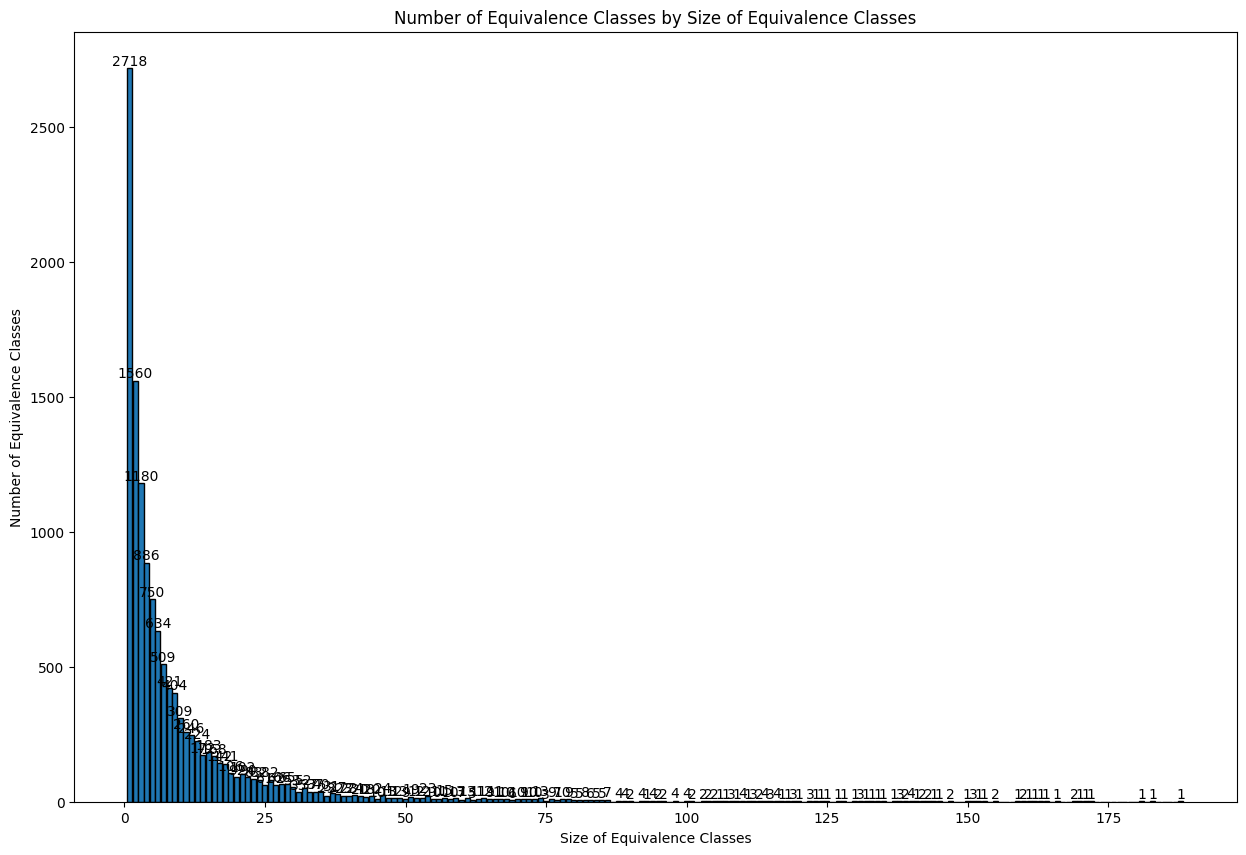

In [361]:
plot_equivalence_graph(dataset)

NOTES (slightly off, after dropping the rows with age_days):
- OPTIMAL: ['gender', 'age_days', 'education', 'home_ownership', 'num_children', 'employment', 'marital_status', 'ethnicity', 'income'] 
	- 6217 (1) 3853 (2), 2892 (3), 2107 (4), 1568 (5), ....
	- excludes postcode & income. For postcode, likely because there are many (123) distinct categories even after reducing / generalising to just the outcode.
- ['gender', 'age_days', 'education', 'home_ownership', 'num_children', 'employment', 'marital_status', 'ethnicity'] 
	- 3136 (1) 2435 (2), 1992 (3), ...
- If include all non-direct / non-sensitive as quasi 
	- 127534 (1), 7038 (2), 484 (3), 39 (4), 3 (5)
- ['gender', 'age_days', 'education', 'home_ownership', 'num_children', 'employment', 'marital_status', 'postcode',] 
	- 72095 (1), 20130 (2), ...
- ['gender', 'age_days', 'education', 'home_ownership', 'num_children', 'employment', 'marital_status', 'income',] 
	- 585 (1), 276 (2), ...




**NB - UPDATE: 05/11. After adding generalization of marital status - this has improved to 2718 in equivalence class 1.**

In [362]:
check_privacy(original_dataset, dataset)

disease: processed 2000 groups (sampled).
malnutrition_score: processed 2000 groups (sampled).
on_benefits: processed 2000 groups (sampled).
=== Privacy Metrics Summary ===
Information loss (quasi-identifiers): 1.370
Minimum k-anonymity: 1

l-diversity (per sensitive column):
  disease              : 1
  malnutrition_score   : 1
  on_benefits          : 1

t-closeness summary:
  Overall mean t-closeness     : 0.345
  Maximum Earth Mover Distance : 0.978

Example group-level t-closeness details (showing up to 5 groups per column):
  disease:
    Group '('female', np.int64(2), np.int64(2), 'Own house', np.int64(0), np.int64(0), np.True_, np.int8(1), np.int64(0))' → Distance=0.503, Within threshold=False
    Group '('female', np.int64(1), np.int64(2), 'Rent room', np.int64(1), np.int64(1), np.False_, np.int8(3), np.int64(1))' → Distance=0.720, Within threshold=False
    Group '('female', np.int64(1), np.int64(1), 'Rent flat', np.int64(1), np.int64(0), np.False_, np.int8(2), np.int64(0))' 

{'information_loss': np.float64(1.3698941102391307),
 'k_anonymity': np.int64(1),
 'l_diversity': {'disease': np.int64(1),
  'malnutrition_score': np.int64(1),
  'on_benefits': np.int64(1)},
 't_closeness': {'overall t closeness': 0.34486237873957754,
  'max emd': 0.9781344430311808,
  'details': {'disease': [{'group value': ('female',
      np.int64(2),
      np.int64(2),
      'Own house',
      np.int64(0),
      np.int64(0),
      np.True_,
      np.int8(1),
      np.int64(0)),
     'distance': 0.502746061038283,
     'within t threshold': np.False_},
    {'group value': ('female',
      np.int64(1),
      np.int64(2),
      'Rent room',
      np.int64(1),
      np.int64(1),
      np.False_,
      np.int8(3),
      np.int64(1)),
     'distance': 0.7195856278443972,
     'within t threshold': np.False_},
    {'group value': ('female',
      np.int64(1),
      np.int64(1),
      'Rent flat',
      np.int64(1),
      np.int64(0),
      np.False_,
      np.int8(2),
      np.int64(0)),


# Remove records with equivalence class of size 1.


In [363]:
def drop_unique_equivalence_classes(dataset, min_size=2):
	# Define the quasi-identifiers
	quasi_identifiers = ['gender', 'age_days', 'education', 'home_ownership', 'num_children', 'employment', 'marital_status', 'ethnicity', 'income']

	# Compute equivalence class sizes for each row
	dataset['eq_class_size'] = dataset.groupby(quasi_identifiers)['gender'].transform('size')

	# Keep only rows where equivalence class size > 1
	dataset = dataset[dataset['eq_class_size'] >= min_size]

	# Drop the helper column if you don’t need it
	dataset = dataset.drop(columns='eq_class_size')

	return dataset


In [364]:
dataset = drop_unique_equivalence_classes(dataset, 2)
print("Shape of dataset after dropping rows of equivalence class size = 1: ",dataset.shape)

Shape of dataset after dropping rows of equivalence class size = 1:  (133295, 15)


C:\Users\yukie\AppData\Local\Temp\ipykernel_49780\202238239.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataset['eq_class_size'] = dataset.groupby(quasi_identifiers)['gender'].transform('size')


In [365]:
check_privacy(original_dataset, dataset)

disease: processed 2000 groups (sampled).
malnutrition_score: processed 2000 groups (sampled).
on_benefits: processed 2000 groups (sampled).
=== Privacy Metrics Summary ===
Information loss (quasi-identifiers): 1.383
Minimum k-anonymity: 2

l-diversity (per sensitive column):
  disease              : 1
  malnutrition_score   : 1
  on_benefits          : 1

t-closeness summary:
  Overall mean t-closeness     : 0.315
  Maximum Earth Mover Distance : 0.978

Example group-level t-closeness details (showing up to 5 groups per column):
  disease:
    Group '('female', np.int64(2), np.int64(2), 'Own flat', np.int64(1), np.int64(1), np.True_, np.int8(3), np.int64(1))' → Distance=0.871, Within threshold=False
    Group '('female', np.int64(1), np.int64(2), 'Rent room', np.int64(1), np.int64(1), np.False_, np.int8(6), np.int64(2))' → Distance=0.696, Within threshold=False
    Group '('female', np.int64(1), np.int64(1), 'Rent room', np.int64(0), np.int64(1), np.True_, np.int8(4), np.int64(1))' → 

{'information_loss': np.float64(1.3832189158594737),
 'k_anonymity': np.int64(2),
 'l_diversity': {'disease': np.int64(1),
  'malnutrition_score': np.int64(1),
  'on_benefits': np.int64(1)},
 't_closeness': {'overall t closeness': 0.31492935527932664,
  'max emd': 0.9781087062530477,
  'details': {'disease': [{'group value': ('female',
      np.int64(2),
      np.int64(2),
      'Own flat',
      np.int64(1),
      np.int64(1),
      np.True_,
      np.int8(3),
      np.int64(1)),
     'distance': 0.8709854083048876,
     'within t threshold': np.False_},
    {'group value': ('female',
      np.int64(1),
      np.int64(2),
      'Rent room',
      np.int64(1),
      np.int64(1),
      np.False_,
      np.int8(6),
      np.int64(2)),
     'distance': 0.6958400540155295,
     'within t threshold': np.False_},
    {'group value': ('female',
      np.int64(1),
      np.int64(1),
      'Rent room',
      np.int64(0),
      np.int64(1),
      np.True_,
      np.int8(4),
      np.int64(1)),
 

In [366]:
benchmark_all(original_dataset, dataset, exclude_age_days=False)

=== Benchmarking All Use Cases ===
Use Case 1: Ethnicity <-> Disease
Ethnicity distribution similarity: 0.000
Disease distribution similarity:   1.000
Ethnicity–Disease correlation similarity: 0.997
→ Overall utility score: 0.666

Use Case 2: Fairness in on_benefits Decision
Distribution similarities: income=0.000, gender=1.000, ethnicity=0.000, marital_status=1.000, education=1.000, employment=1.000, num_children=1.000, home_ownership=1.000, age_days=1.000
Correlation similarities: income↔on_benefits=0.000, gender↔on_benefits=0.000, ethnicity↔on_benefits=0.000, marital_status↔on_benefits=0.000, education↔on_benefits=0.000, employment↔on_benefits=0.000, num_children↔on_benefits=0.000, home_ownership↔on_benefits=0.000, age_days↔on_benefits=0.000
→ Overall utility score: 0.647

Use Case 3: Geographic + Qualifications ↔ Malnutrition
Distribution similarities: postcode=1.000, education=0.000, malnutrition=0.996
Correlation similarities: postcode↔malnutrition=1.000, education↔malnutrition=0

np.float64(0.6757718743913808)

In [367]:
# suppress rows in equivalence classes smaller than k_min
def suppress_low_k(dataset, quasi_identifiers, k_min=5):
    # count group sizes for each quasi-ID combination
    group_sizes = dataset.groupby(quasi_identifiers, observed=True).size().reset_index(name='count')
    dataset = dataset.merge(group_sizes, on=quasi_identifiers, how='left')
    
    before = len(dataset)
    dataset_suppressed = dataset[dataset['count'] >= k_min].drop(columns='count')
    after = len(dataset_suppressed)

    print(f"Suppressed {before - after} records ({100*(before-after)/before:.2f}% of data) to ensure k ≥ {k_min}.")
    return dataset_suppressed

# iteratively calls suppress low k until k ≥ k_target
def improve_k_anonymity(dataset, original_dataset, quasi_identifiers, k_target=5, bin_step=5):
    current_k = k_anonymity(dataset, quasi_identifiers)

    while current_k < k_target:
        print(f"\nCurrent k = {current_k} < target {k_target}.")
        dataset = suppress_low_k(dataset, quasi_identifiers, k_min=current_k+1)
        current_k = k_anonymity(dataset, quasi_identifiers)

    print(f"\n✅ Achieved k ≥ {current_k}.")
    check_privacy(original_dataset, dataset)
    return dataset


In [368]:
dataset = improve_k_anonymity(dataset, original_dataset, QUASI_IDS, k_target=5)


Current k = 2 < target 5.
Suppressed 3120 records (2.34% of data) to ensure k ≥ 3.

Current k = 3 < target 5.
Suppressed 3540 records (2.72% of data) to ensure k ≥ 4.

Current k = 4 < target 5.
Suppressed 3544 records (2.80% of data) to ensure k ≥ 5.

✅ Achieved k ≥ 5.
disease: processed 2000 groups (sampled).
malnutrition_score: processed 2000 groups (sampled).
on_benefits: processed 2000 groups (sampled).
=== Privacy Metrics Summary ===
Information loss (quasi-identifiers): 1.425
Minimum k-anonymity: 5

l-diversity (per sensitive column):
  disease              : 2
  malnutrition_score   : 5
  on_benefits          : 1

t-closeness summary:
  Overall mean t-closeness     : 0.265
  Maximum Earth Mover Distance : 0.891

Example group-level t-closeness details (showing up to 5 groups per column):
  disease:
    Group '('female', np.int64(1), np.int64(2), 'Rent house', np.int64(0), np.int64(1), np.True_, np.int8(2), np.int64(2))' → Distance=0.624, Within threshold=False
    Group '('male

In [369]:
benchmark_all(original_dataset, dataset, exclude_age_days=False)

=== Benchmarking All Use Cases ===
Use Case 1: Ethnicity <-> Disease
Ethnicity distribution similarity: 0.000
Disease distribution similarity:   1.000
Ethnicity–Disease correlation similarity: 0.998
→ Overall utility score: 0.666

Use Case 2: Fairness in on_benefits Decision
Distribution similarities: income=0.000, gender=1.000, ethnicity=0.000, marital_status=1.000, education=1.000, employment=1.000, num_children=1.000, home_ownership=1.000, age_days=1.000
Correlation similarities: income↔on_benefits=0.000, gender↔on_benefits=0.000, ethnicity↔on_benefits=0.000, marital_status↔on_benefits=0.000, education↔on_benefits=0.000, employment↔on_benefits=0.000, num_children↔on_benefits=0.000, home_ownership↔on_benefits=0.000, age_days↔on_benefits=0.000
→ Overall utility score: 0.647

Use Case 3: Geographic + Qualifications ↔ Malnutrition
Distribution similarities: postcode=1.000, education=0.000, malnutrition=0.983
Correlation similarities: postcode↔malnutrition=1.000, education↔malnutrition=0

np.float64(0.6743524893547933)

## Improving l-diversity of "on_benefits" 

We now have decent privacy metrics with k >= 5, and l-diversity (2 for disease, 5 for malnutrition score), and average t-closeness 0.265. However the l-diversity for "on_benefits" is 1, which is not ideal.

We want to now try to improve on this, otherwise if an attacker knows someone’s quasi-identifier combo, they can deduce their benefits status exactly.

### TODO


In [ ]:
print(f"Original dataset shape: {original_dataset.shape}")
print(f"Processed dataset shape: {dataset.shape}")

# calculate percentage difference of rows dropped
diff = original_dataset.shape[0] - dataset.shape[0]
percent_diff = (diff / original_dataset.shape[0]) * 100
print(f"Rows dropped: {diff} ({percent_diff:.2f}%)")

Original dataset shape: (150000, 14)
Processed dataset shape: (123091, 15)
Rows dropped: 26909 (17.94%)


## Evaluate effect of microswapping groups - doesn't improve so we don't use

The idea we want to try and then evaluate to see if improves anyting: While column-wise micro-swapping improves 
𝑙-diversity and 
𝑡-closeness, it can distort the correlations relied on in our defined utility cases.
Thus to introduce stochastic uncertainty (reducing linkability) whilst still preserving the 3 specific usecases, we try to perform swaps across entire column *groups* that participate in the same use case. This means when checking those columns for a usecase, the distributions and correlations does not change.

Resulting evaluation:
However, we found that this would in fact worsen privacy metrics k-anonmity, l-diversity, and t-closness since the random swapping broke internal consistencies (some classes became unique again).

In [370]:
# swap sets of columns (used together in a utility case) between random equivalence classes to improve protection against linkage attacks
def improve_group_swaps(df, quasi_ids, swap_group, max_swaps=500, seed=0):
    import numpy as np
    rng = np.random.default_rng(seed)
    df = df.copy()

    # group once; give every group a numeric ID (0..G-1)
    grouped = df.groupby(quasi_ids, observed=True).indices
    group_keys = list(grouped.keys())
    group_ids = {i: np.array(v, dtype=int) for i, (_, v) in enumerate(grouped.items())}

    swaps = 0
    n_groups = len(group_ids)
    if n_groups < 2:
        print("Not enough equivalence classes to swap.")
        return df

    while swaps < max_swaps:
        # choose two random groups by integer ID
        g1, g2 = rng.choice(n_groups, 2, replace=False)
        idx1 = rng.choice(group_ids[g1])
        idx2 = rng.choice(group_ids[g2])

        # swap all columns in the use-case group
        for col in swap_group:
            val1, val2 = df.at[df.index[idx1], col], df.at[df.index[idx2], col]
            df.at[df.index[idx1], col], df.at[df.index[idx2], col] = val2, val1

        swaps += 1

    print(f"Performed {swaps} grouped swaps for columns {swap_group}.")
    return df


In [371]:
USECASE_3 = ['on_benefits', 'home_ownership', 'num_children']
dataset_swapped = improve_group_swaps(dataset, QUASI_IDS, USECASE_3, max_swaps=1000)
check_privacy(original_dataset, dataset_swapped)


Performed 1000 grouped swaps for columns ['on_benefits', 'home_ownership', 'num_children'].
disease: processed 2000 groups (sampled).
malnutrition_score: processed 2000 groups (sampled).
on_benefits: processed 2000 groups (sampled).
=== Privacy Metrics Summary ===
Information loss (quasi-identifiers): 1.425
Minimum k-anonymity: 1

l-diversity (per sensitive column):
  disease              : 1
  malnutrition_score   : 1
  on_benefits          : 1

t-closeness summary:
  Overall mean t-closeness     : 0.273
  Maximum Earth Mover Distance : 0.978

Example group-level t-closeness details (showing up to 5 groups per column):
  disease:
    Group '('female', np.int64(1), np.int64(2), 'Rent house', np.int64(1), np.int64(0), np.False_, np.int8(2), np.int64(1))' → Distance=0.227, Within threshold=False
    Group '('male', np.int64(1), np.int64(2), 'Rent room', np.int64(1), np.int64(0), np.True_, np.int8(2), np.int64(0))' → Distance=0.337, Within threshold=False
    Group '('male', np.int64(3), 

{'information_loss': np.float64(1.4245143591389255),
 'k_anonymity': np.int64(1),
 'l_diversity': {'disease': np.int64(1),
  'malnutrition_score': np.int64(1),
  'on_benefits': np.int64(1)},
 't_closeness': {'overall t closeness': 0.2731442462758271,
  'max emd': 0.9779918921773322,
  'details': {'disease': [{'group value': ('female',
      np.int64(1),
      np.int64(2),
      'Rent house',
      np.int64(1),
      np.int64(0),
      np.False_,
      np.int8(2),
      np.int64(1)),
     'distance': 0.22747538875241144,
     'within t threshold': np.False_},
    {'group value': ('male',
      np.int64(1),
      np.int64(2),
      'Rent room',
      np.int64(1),
      np.int64(0),
      np.True_,
      np.int8(2),
      np.int64(0)),
     'distance': 0.3373540713780861,
     'within t threshold': np.False_},
    {'group value': ('male',
      np.int64(3),
      np.int64(2),
      'Rent flat',
      np.int64(2),
      np.int64(0),
      np.False_,
      np.int8(3),
      np.int64(1)),
  